In [ ]:
import copy
import random
import sys 
import torch
import ipynb
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
# import DL_model_3
from ipynb.fs.full.dl_model import DL
from ipynb.fs.full.hwes_model import HwesPredictor 
from ipynb.fs.full.sarima_model import SarimaxPredictor 
# import sliding_window as sw
from ipynb.fs.full.interpolated_time_series import interpolated_time_series
# import training_datasets as td

random.seed(1)
torch.manual_seed(1)

In [3]:
def sliding_window(ts, features):
    
    """
    features mean that you need to separate how many features i.e. sliding window to get into the model
    """
    X = []
    Y = []
    for i in range(features + 1, len(ts) + 1):
        X.append(ts[i - (features + 1): i - 1])
        Y.append([ts[i - 1]])
    
    return X, Y
    

def get_training_datasets(features, test_len):
    """
    import data and then split data into different parts for training, testing and valuation
    """
    ts = interpolated_time_series()
    X, Y = sliding_window(ts, features)
    X_train, Y_train, X_test, Y_test = X[0:-test_len], Y[0:-test_len], X[-test_len:], Y[-test_len:]
    train_len = round(len(ts) * 0.7)
    X_train, X_val, Y_train, Y_val = X_train[0:train_len], X_train[train_len:], Y_train[0:train_len], Y_train[train_len:]
    x_train = torch.tensor(data = X_train)
    y_train = torch.tensor(data = Y_train)
    x_val = torch.tensor(data = X_val)
    y_val = torch.tensor(data = Y_val)
    x_test = torch.tensor(data = X_test)
    y_test = torch.tensor(data = Y_test)
    
    return x_train, x_val, x_test, y_train, y_val, y_test

# if __name__ == '__main__':
#     ts = list(range(6))
#     ts = interpolated_time_series()
#     X, Y = sliding_window(ts, 60)
#     print(f'Time series: {ts}')
#     print(f'X: {X}')
#     print(f'Y: {Y}')

In [4]:
features = 120
# features = 10

In [ ]:
# Split into three dataset and train them  
x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(features, 40)


net = DL(n_inp = features, l_1 = 400, l_2 = 48, conv1_out = 6, conv1_kernel = 6, conv2_kernel = 12, drop1 = .1)
net.train()
sarima_predictor = SarimaxPredictor()
hwes_predictor = HwesPredictor()

optimizer = torch.optim.Adam(params = net.parameters())  # find gradient descent models
abs_loss = torch.nn.L1Loss()  # Check mean squared error that takes input and output 
best_model = None

min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(150):
    prediction = net(x_train) # Find value prediction for prediction
    loss = abs_loss(prediction, y_train)
    optimizer.zero_grad()  # Zero gradient - back to zero 

    loss.backward()  # Find the minimal loss of the gradient descent  
    optimizer.step() # learning rate 
    
    val_prediction = net(x_val) # Find value prediction for valuation prediction - generate a prediction number and below calculate MSE values
    val_loss = abs_loss(val_prediction, y_val)  # MSE - to find the value of loss
    
    training_loss.append(loss.item()) # loss item - append loss value into the list
    validation_loss.append(val_loss.item()) # Loss item - append to validation 
    
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss.item()
    
        if t % 10 == 0:
            print(f'epoch {t}: train - {round(loss.item(), 4)}, 'f'val: - {round(val_loss.item(), 4)}')
                  

epoch 0: train - 6.0283, val: - 6.5117


In [7]:
net.eval()
dl_prediction = best_model(x_test)
# sarima_prediction = sarima_predictor(x_test)
# hwes_prediction = sarima_predictor(x_test)
dl_abs_loss = round(abs_loss(dl_prediction, y_test).item(), 4)
# sarima_abs_loss = round(abs_loss(sarima_prediction, y_test).item(), 4)
# hwes_abs_loss = round(abs_loss(hwes_prediction, y_test).item(), 4)

In [8]:
print("=============================")
print('Results on Test Dataset')
print(f'DL Loss: {dl_abs_loss}')
# print(f'SARIMA Loss: {sarima_abs_loss}')
# print(f'HWES Loss: {hwes_abs_loss}')

Results on Test Dataset
DL Loss: 0.8587


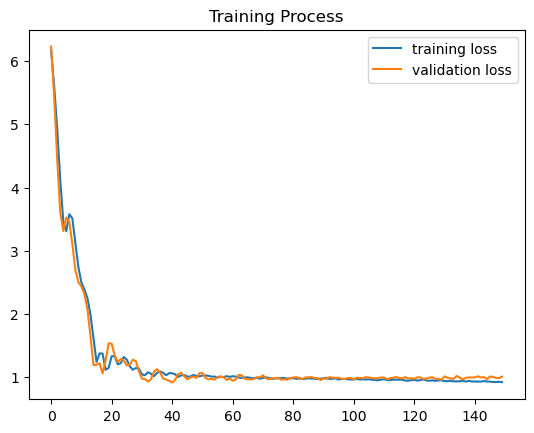

In [9]:
plt.title("Training Process")
plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')
plt.legend()
plt.show()

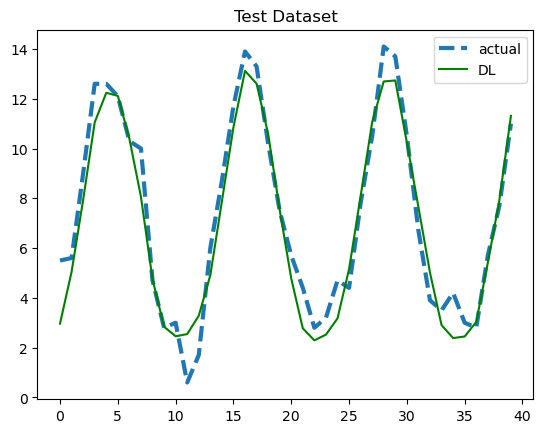

In [10]:
plt.title("Test Dataset")
plt.plot(y_test,'--', label = 'actual', linewidth = 3)
plt.plot(best_model(x_test).tolist(), label = 'DL', color = 'g')
# plt.plot(sarima_prediction.tolist(), label = 'SARIMA', color = 'r')
# plt.plot(hwes_prediction.tolist(), label = 'HWES', color = 'brown')
plt.legend()
plt.show()

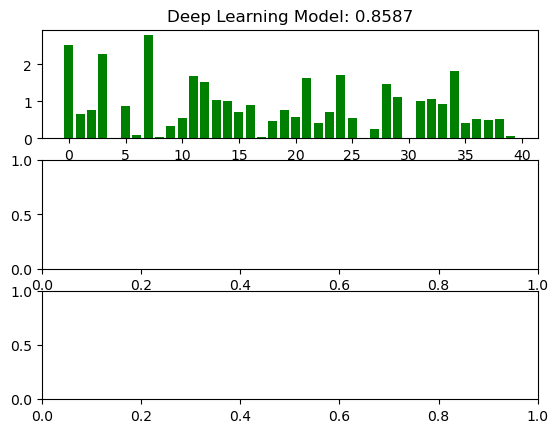

In [11]:
test_n = len(y_test)
dl_abs_dev = (dl_prediction - y_test).abs_()
# sarima_abs_dev = (sarima_prediction - y_test).abs_()
# hwes_abs_dev = (hwes_prediction - y_test).abs_()
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_title(f'Deep Learning Model: {dl_abs_loss}')
ax1.bar(list(range(test_n)), dl_abs_dev.view(test_n).detach().numpy(), color = 'g')
# ax2.set_title(f'SARIMA Model: {sarima_abs_loss}')
# ax2.bar(list(range(test_n)), sarima_abs_dev.view(test_n).detach().numpy(), color = 'r')
# ax3.set_title(f'HWES Model: {hwes_abs_loss}')
# ax3.bar(list(range(test_n)), hwes_abs_dev.view(test_n).detach().numpy(), color = 'brown')
plt.show()

In [8]:
print(interpolated_time_series())

[347.527954, 359.840363, 357.854492, 356.464386, 365.003662, 365.003662, 388.635559, 392.011536, 393.60022, 374.33725, 373.34433, 377.117462, 365.003662, 366.790924, 368.18103, 378.309021, 367.386688, 372.351379, 381.48642, 375.528809, 363.216339, 362.422028, 351.896881, 344.549164, 346.336426, 345.144928, 349.116669, 350.109589, 339.981628, 335.414124, 333.031067, 332.633911, 322.704529, 330.250854, 330.846619, 336.208496, 331.640961, 329.65509, 324.094635, 327.073456, 317.938446, 318.53418, 304.633057, 297.483948, 292.916412, 300.462738, 309.796356, 305.427429, 297.285339, 295.895233, 293.512177, 301.455688, 302.051453, 298.27829, 300.859924, 301.058533, 310.39212, 312.775177, 308.40625, 310.590698, 307.810486, 322.704529, 321.910187, 320.718658, 321.314423, 324.889008, 322.307373, 326.279114, 316.746918, 311.980835, 309.39917, 299.668396, 304.831665, 302.647186, 297.483948, 297.881104, 291.12915, 286.958801, 291.327728, 283.97998, 281.00119, 273.057678, 281.199768, 278.816711, 272.0